<a href="https://colab.research.google.com/github/OwenHuels/data-science/blob/main/OwenHuelU8proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

In [2]:
!pip install pymc-bart
!pip install preliz

import pymc_bart as pmb
import preliz as pz

#**Unit 8 Project: Predicting Cruise Ship Capacity Using BART Models**

##**Context**

Cruise ships hold a lot of people (crazy I know), but not every cruise ship is the same. Lots of different companies build different sized cruise ships to accomodate different amounts of passengers.

This data set contains data from around 150 ships constructed over the last couple decades. I created a DAG, and from that decided that passengers would be the best variable to predict based on the number of other variables that should influence it.

A couple variables that you may not be familiar with:
* Tonnage is just the volume enclosed by a ship, used to estimate what it can carry
* PassSpcR (PassengerSpace) is the amount of tonnage available to each passenger
* OutCab (OutCabins) is the number of cabins which have windows facing the exterior of the ship

Now for the interesting part!

##**Data**

Before we begin to create and test models, here is the raw data.

In [3]:
#raw data csv from my github
url_cruise = 'https://raw.githubusercontent.com/OwenHuels/data-science/main/cruise_ship.csv'

cruise = pd.read_csv(url_cruise)

#view data
cruise

,Ship,Line,YearBlt,Tonnage,passngrs,Length,Cabins,Crew,PassSpcR,outcab
0,Journey,Azamara,2007,30277,694,594,355,355,42.64,329
1,Quest,Azamara,2007,30277,694,594,355,355,42.64,329
2,Celebration,Carnival,1987,47262,1486,722,743,670,31.80,453
3,Conquest,Carnival,2002,110000,2974,953,1488,1910,36.99,892
4,Destiny,Carnival,1996,101353,2642,892,1321,1000,38.36,740
...,...,...,...,...,...,...,...,...,...,...
153,Taurus,Star,1991,3341,66,279,33,59,50.62,33
154,Virgo,Star,1999,76800,1960,879,967,1200,39.18,608
155,Spirit,Windstar,1988,5350,158,440,74,88,33.86,74
156,Star,Windstar,1986,5350,167,440,74,88,32.04,74


In [4]:
#rename columns because I like these names better
cruise.rename(columns={'outcab': 'OutCabins', 'passngrs': 'Passengers', 'PassSpcR': 'PassengerSpace', 'YearBlt': 'YearBuilt'}, inplace=True)
cruise

,Ship,Line,YearBuilt,Tonnage,Passengers,Length,Cabins,Crew,PassengerSpace,OutCabins
0,Journey,Azamara,2007,30277,694,594,355,355,42.64,329
1,Quest,Azamara,2007,30277,694,594,355,355,42.64,329
2,Celebration,Carnival,1987,47262,1486,722,743,670,31.80,453
3,Conquest,Carnival,2002,110000,2974,953,1488,1910,36.99,892
4,Destiny,Carnival,1996,101353,2642,892,1321,1000,38.36,740
...,...,...,...,...,...,...,...,...,...,...
153,Taurus,Star,1991,3341,66,279,33,59,50.62,33
154,Virgo,Star,1999,76800,1960,879,967,1200,39.18,608
155,Spirit,Windstar,1988,5350,158,440,74,88,33.86,74
156,Star,Windstar,1986,5350,167,440,74,88,32.04,74


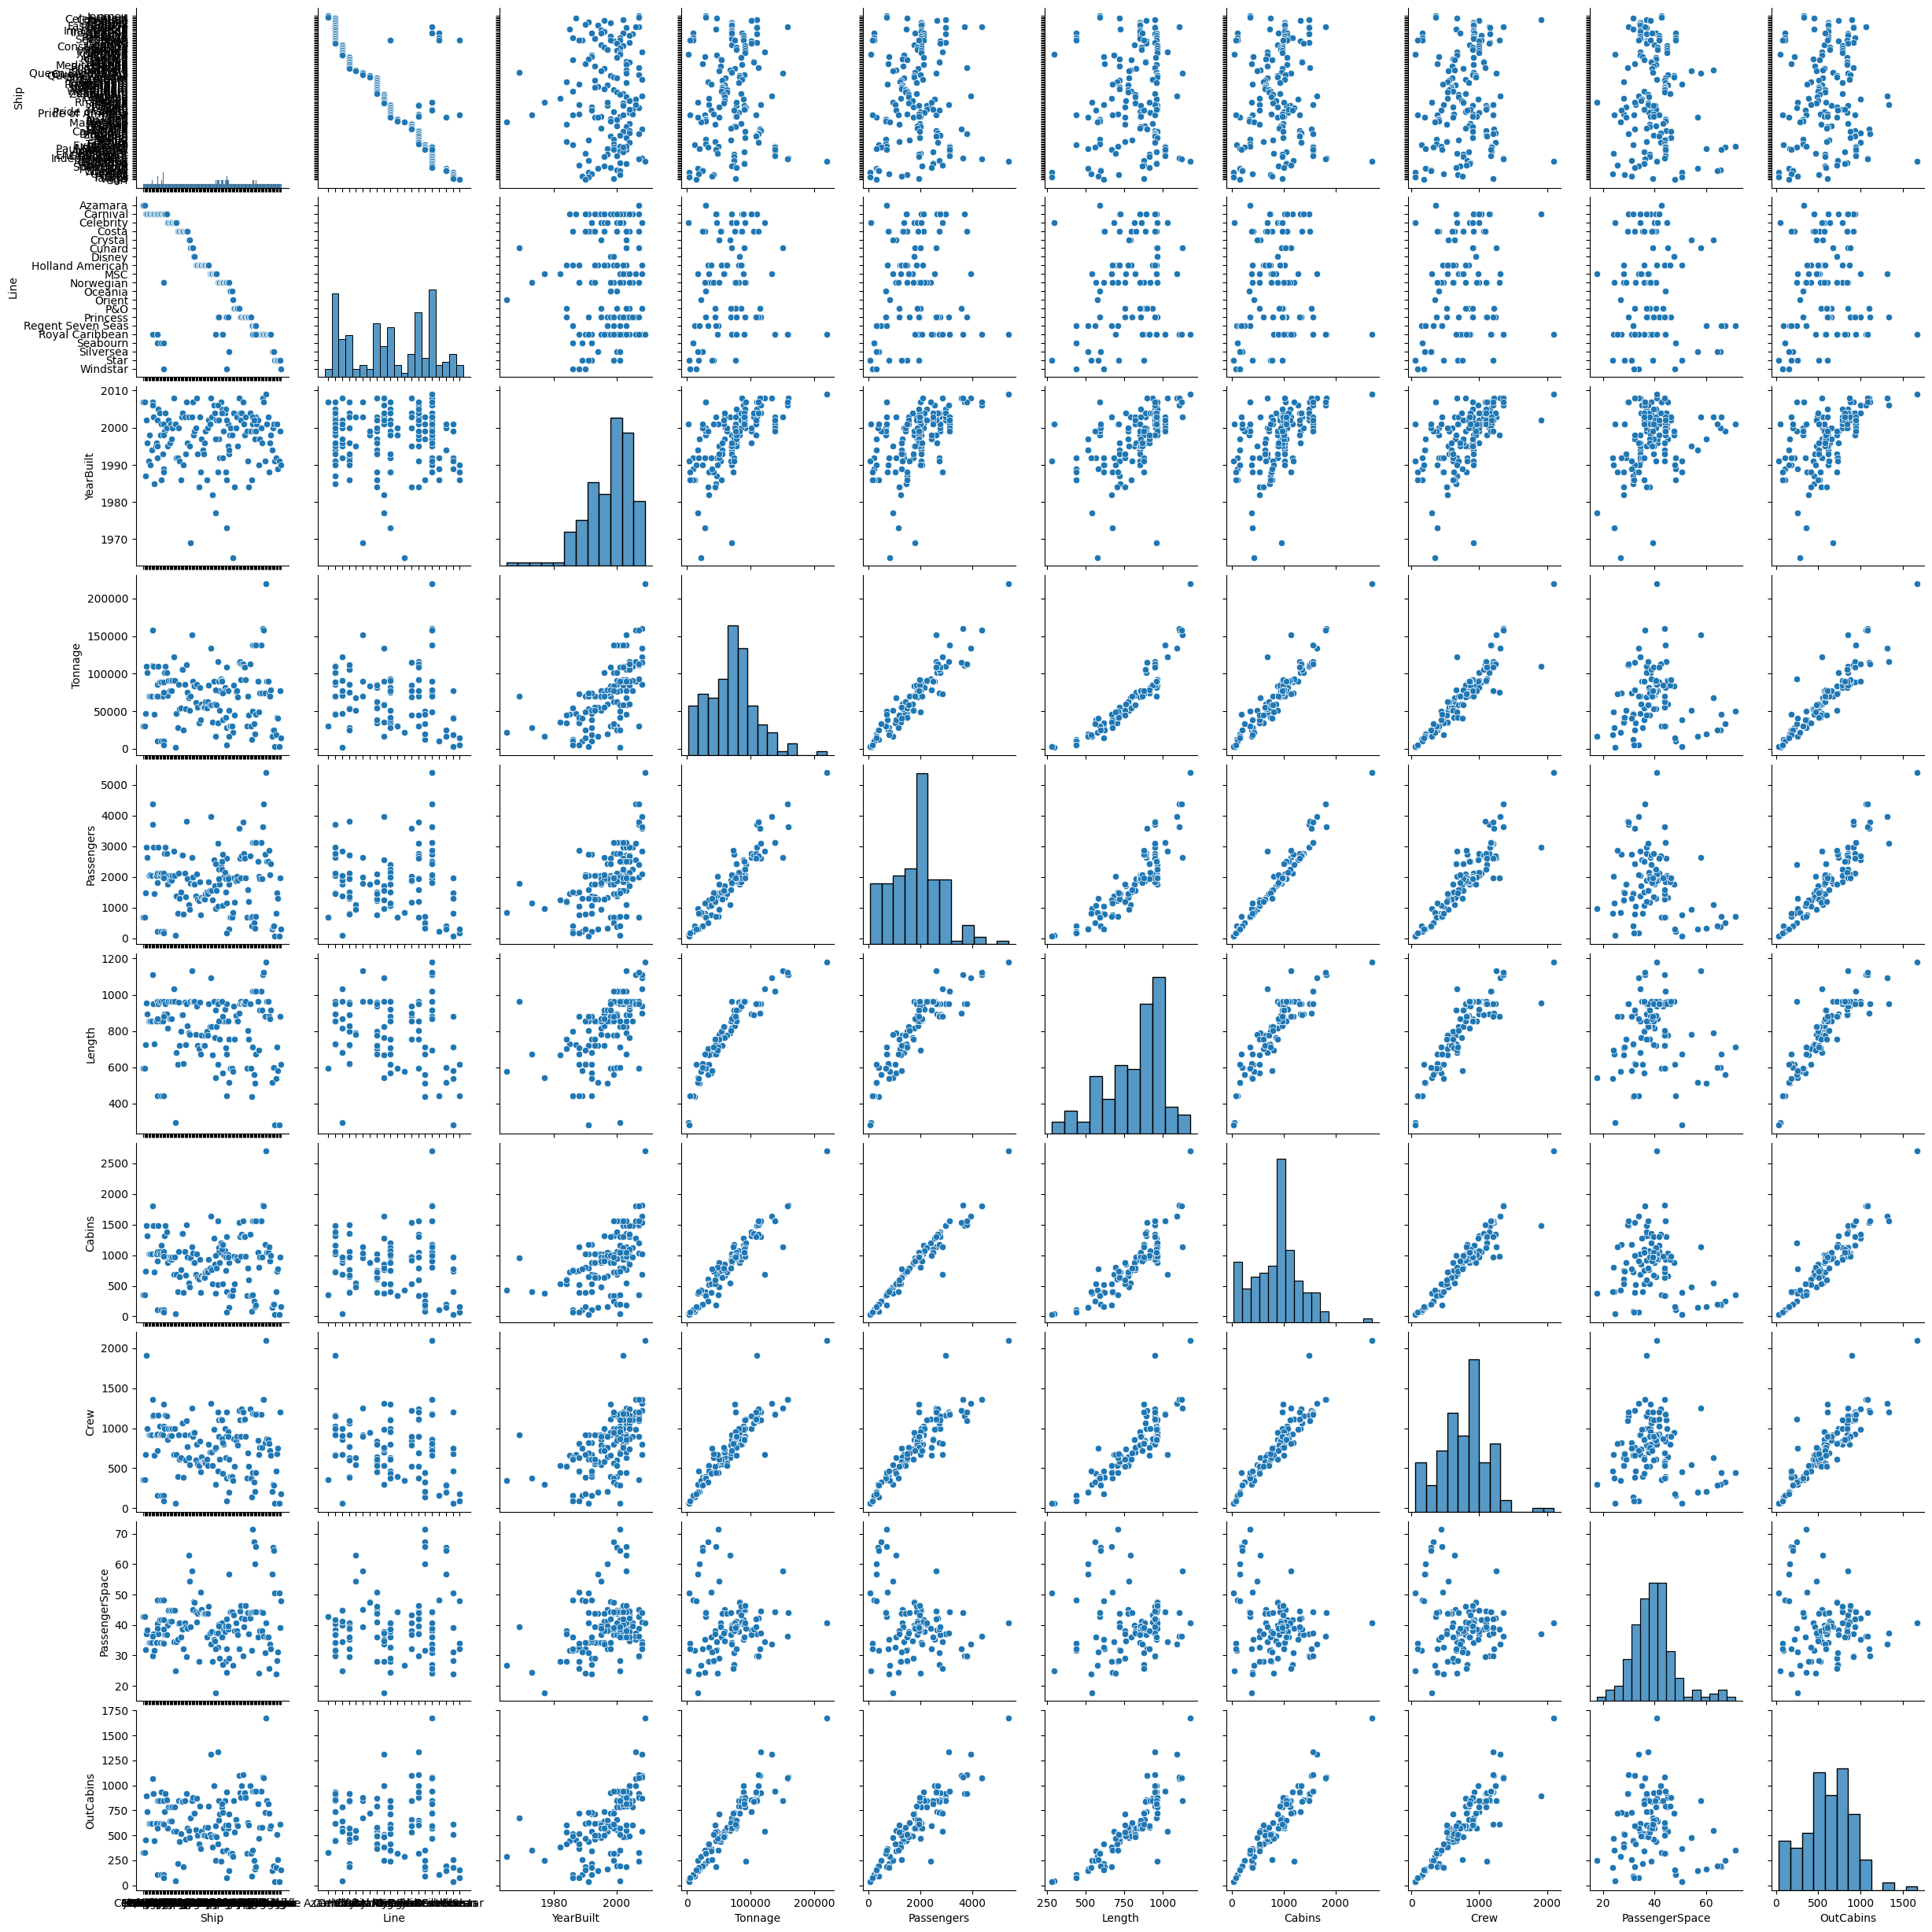

In [5]:
sns.pairplot(cruise, y_vars=cruise.columns, x_vars=cruise.columns, kind='scatter')

Judging by these scatter plots, it seems like my decision to make passengers my predicted variable was a good one. There a lot of predictors that appear to have strong correlation with the number of passengers a cruise ship can carry.

The predictors that I beleive are the strongest or most interesting, which I will include in by BART model, are as follows:
* YearBuilt
* Tonnage
* Length
* Cabins
* Crew

Let's get a straight up visualization of our data to see what we're working with.

(array([16., 19., 27., 51., 19., 17.,  4.,  2.,  2.,  1.]),
 array([  66. ,  599.4, 1132.8, 1666.2, 2199.6, 2733. , 3266.4, 3799.8,
        4333.2, 4866.6, 5400. ]),
 <BarContainer object of 10 artists>)

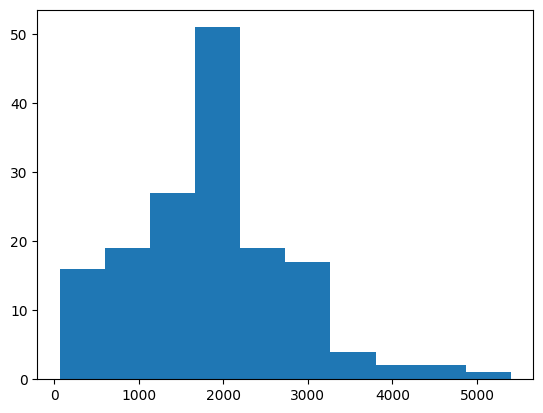

In [6]:
plt.hist(cruise.Passengers)

It looks like a normal likelihood should be just fine for this distribution of data, so I'll go ahead and use that.

Here is a visualization of my data based primarily on yards, which I suspect will be the strongest predictors.

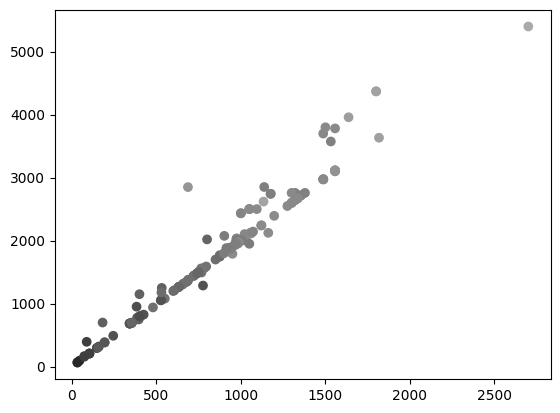

In [7]:
x = cruise.Cabins.tolist()
y = cruise.Passengers.tolist()
z = cruise.Length.tolist()

color = [str(item/(max(z)+max(z)/2)) for item in z]

plt.scatter(x, y, c=color)

plt.show()

##**Models**

Here's the list of those variables I mentioned earlier that we'll need for the model.

In [8]:
clmn_list = ['YearBuilt',
             'Tonnage',
             'Passengers',
             'Length',
             'Cabins',
             'Crew'
             ]
vars =  cruise.loc[:,clmn_list]
vars

,YearBuilt,Tonnage,Passengers,Length,Cabins,Crew
0,2007,30277,694,594,355,355
1,2007,30277,694,594,355,355
2,1987,47262,1486,722,743,670
3,2002,110000,2974,953,1488,1910
4,1996,101353,2642,892,1321,1000
...,...,...,...,...,...,...
153,1991,3341,66,279,33,59
154,1999,76800,1960,879,967,1200
155,1988,5350,158,440,74,88
156,1986,5350,167,440,74,88


In [9]:
clmn_list = ['YearBuilt',
             'Tonnage',
             'Length',
             'Cabins',
             'Crew'
             ]
X =  cruise.loc[:,clmn_list]
Y = cruise.Passengers.to_numpy()

Now for the model itself, with normal likelihood as previously established.

In [10]:
with pm.Model() as model_cruise_all:
    s = pm.HalfNormal('s',20)
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50)
    μ = pm.Deterministic("μ",pm.math.exp(μ_))
    y = pm.Normal("y", mu=μ, sigma=s,  observed=Y)
    idata_cruise_all = pm.sample(compute_convergence_checks=False)

Output()

Output()

<Axes: xlabel='y'>

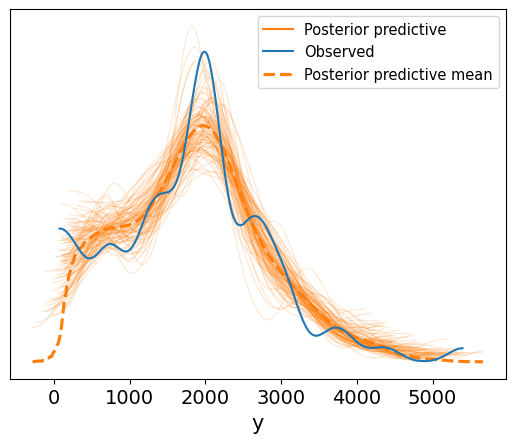

In [11]:
pm.sample_posterior_predictive(idata_cruise_all,model_cruise_all, extend_inferencedata=True)
az.plot_ppc(idata_cruise_all, num_pp_samples=100, colors=["C1", "C0", "C1"])

This posterior predictive looks pretty solid. The behavior on the right end evens out some of the bumps that I would suspect are just noise, so that's good to see. The peak is a bit lower than the peak of the observed data. The behavior on the left end is likely an artifact of the part model using a normal likelihood and wanting to rever to 0 at the edge, which the BART model encourages because it wants to flatten out at the edges. That's the only behavior that I would say is significantly off from what the data shows.

Now for some plots so we can further analyze!

In [12]:
posterior_mean = idata_cruise_all.posterior["μ"]

μ_hdi = az.hdi(ary=idata_cruise_all, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata_cruise_all, group="posterior_predictive", var_names=["y"]
).T

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


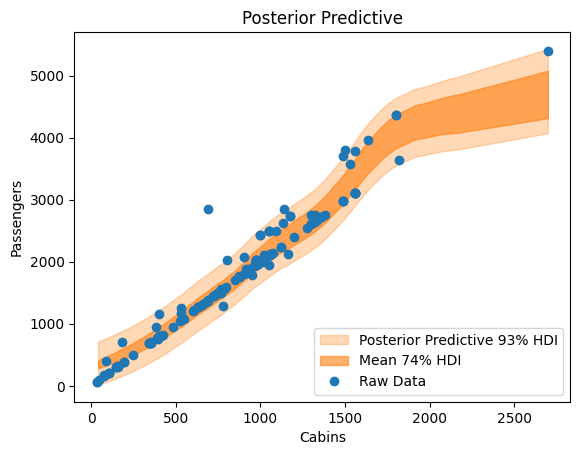

In [13]:
idx = vars.Cabins
fig, ax = plt.subplots()

az.plot_hdi(
    x=vars.Cabins,
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive 93% HDI"},
)

az.plot_hdi(
    x=vars.Cabins,
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean 74% HDI"},
)
ax.plot(cruise["Cabins"], cruise["Passengers"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="Cabins",
    ylabel="Passengers",
);

Our model fits the data pretty much exactly. There's a few outliers, like that point way up at 3000 passengers while only having 750 cabins, but other than that, everything falls in line. It's good that the model doesn't try to veer way off to incorperate these outliers. The model tries to flatten out at the end which I don't think is accurate, but that's just because of BART model's behavior.

Here are the partial dependence, individual conditional expectation, and variable importance plots generated for our model.

array([<Axes: xlabel='YearBuilt'>, <Axes: xlabel='Tonnage'>,
       <Axes: xlabel='Length'>, <Axes: xlabel='Cabins'>,
       <Axes: xlabel='Crew'>], dtype=object)

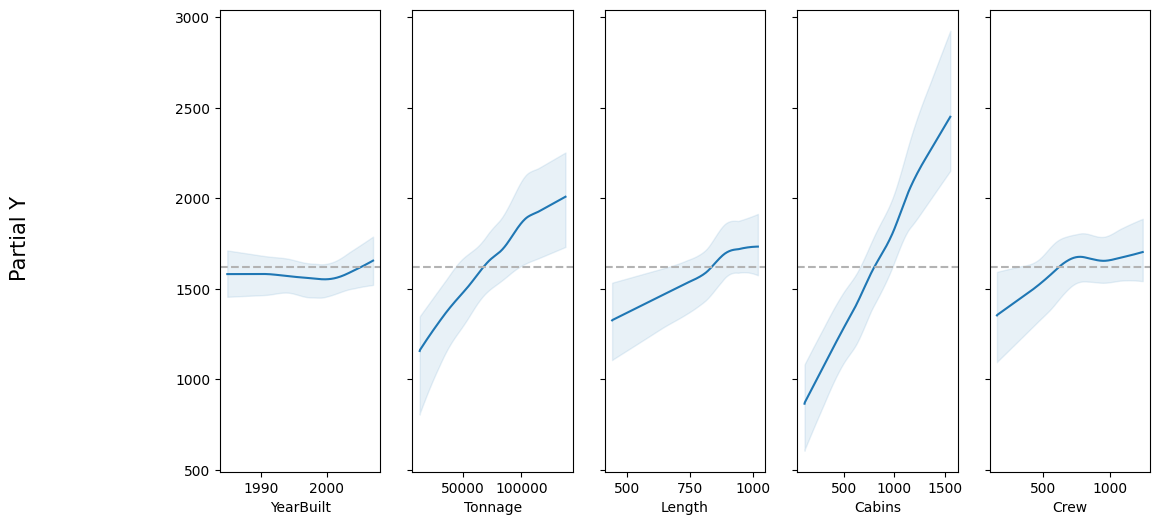

In [14]:
pmb.plot_pdp(μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

array([<Axes: xlabel='YearBuilt'>, <Axes: xlabel='Tonnage'>,
       <Axes: xlabel='Length'>, <Axes: xlabel='Cabins'>,
       <Axes: xlabel='Crew'>], dtype=object)

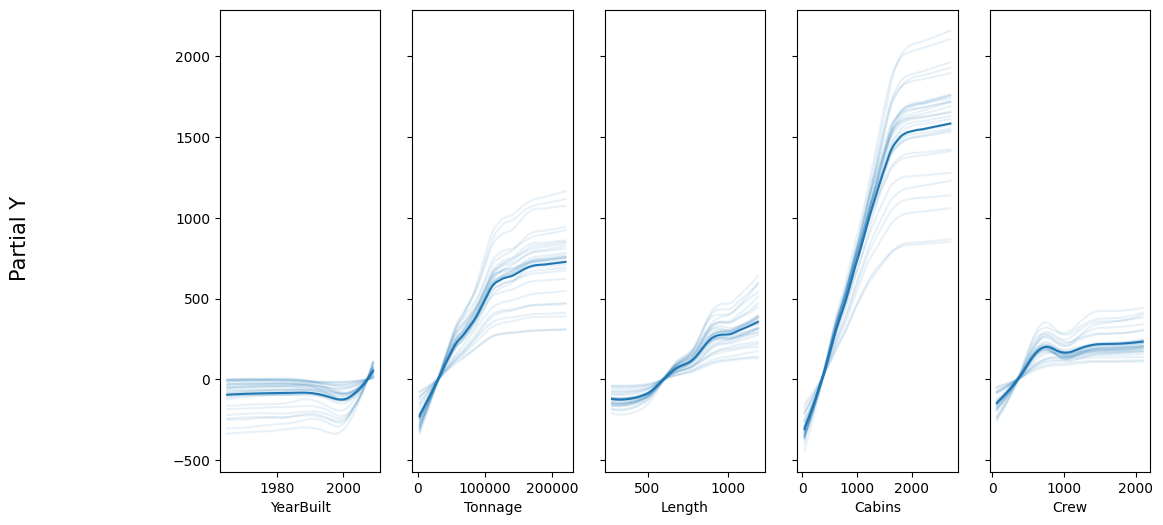

In [15]:
pmb.plot_ice( μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

In [16]:
vi_cruise_all = pmb.compute_variable_importance(idata_cruise_all, μ_, X)

<Axes: ylabel='R²'>

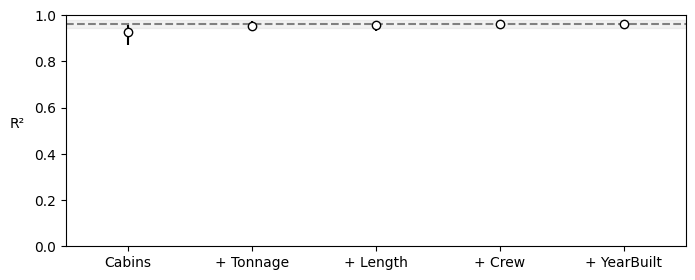

In [17]:
pmb.plot_variable_importance(vi_cruise_all)

Below is my analysis of these plots and conclusion.

##**Conclusion**

The **partial dependence** (pdp) plot seems to show that the tonnage of the ship and number of cabins are the strongest predictors of passenger capacity, while length is also pretty solid. This makes sense to me, as cruise ships tend to hold a pretty stead 2 passengers per cabin ratio, resulting in a very linear trend. (That one outlier from before that we saw at around 3000 passengers for 750 cabins actually has a 4:1 ratio, so maybe that's a ship meant for families?). Crew looks like a solid predictor to begin with, before flattening out for higher passenger counts. Every cruise ship needs a baseline number of employees on board to function, increasing certain positions (kitchen staff, cleaners, etc.) with the number of passengers. But once the number of passengers gets high enough, this tops out a bit because you don't have that spike in the baseline, manegerial employee requirements as much.

The **individual conditional expectation** (ice) plot indicates a few relationships between our predictors. Cabins remains parallel for most of the range, but the strength varies widely on the right side. The lines for length vary more in slope as you move to the right, indicating some sort of interaction is present (I would guess with tonnage, but further investigation would be necessary to be sure). This plot also shows that year built is clearly an unreliable predictor given all of the wacky stuff going on with individual lines compared to their mean, so we probably shouldn't use that as a predictor. Crew and tonnage both have relatively parallel lines, except for crew at 1000 crew members, where there is an odd downward bulge. I suspect this is just noise due to one or two cruiselines having a line of ships with 1000 crew members but less passengers than average (maybe luxury cruises?), but more data would be necessary to be sure.

The **variable importance** (vi) plot confirms most of what we believe to be true about the most importance predictors that we gathered from the other plots. Cabins alone is a very strong predictor, and just adding in tonnage gets us to basically as good of a model as we could hope for. It is interesting that length is seeming not very important. I would not expect this, as the a longer ship should result in more capacity for passengers, but it appears that this trend is somewhat inconsistent.

Overall, the BART model did a pretty excellent job of modeling this data in a way that I feel is accurate to the real world. I think that the trend should continue going up and to the right at the right edge of the data, but that behavior is mostly just caused by the fact that very few cruise ships can carry that many passengers, resulting in anything out there being an outlier. I would like to see in the future if I could run this model on a larger data set of cruise ships, because 150 isn't too large of a sample size. I think just using number of cabins and tonnage of a cruise ship to predict passenger capacity would be sufficient for real world applications. Looking at the original scatter plots, it seems that a lot of our predictor variables have linear trends with eachother, so there's a lot of possible interactions to explore.